# Koopman kernel: Spectral consistency analysis

In this notebook we analyse the consistency of implied time scales obtained from the spectrum of the Koopman operator.

In [1]:
# %matplotlib inline
from itertools import product

import matplotlib.pyplot as plt

import os
import pickle
import numpy as np

from klearn_tcyclone.climada.tc_tracks_tools import BASINS

Import data functions

In [2]:
def load_data(time_step_h, year_range, num_centers, tikhonov_reg, context_lengths, time_lags, reduced_rank = None):
    if reduced_rank is None:
        reduced_rank = False
    model_config = {
        "length_scale": 10.0,
        "reduced_rank": reduced_rank,
        "rank": 50,
        "num_centers": num_centers,
        "tikhonov_reg": tikhonov_reg,
        "svd_solver": "arnoldi",
        "rng_seed": 42,
    }

    folder_name = "_".join(
        [
            "year_range",
            *map(str, year_range),
            "clengths",
            *map(str, context_lengths),
            "tlags",
            *map(str, time_lags),
        ]
    )
    load_path = os.path.join(
        "../data/", "koopman_spectral_analysis/", "time_lag_scaling/", folder_name
    )

    evals = {}
    errors = {}
    time_scales = {}
    for context_length in context_lengths:
        print("Load data for context length:", context_length)

        if model_config["reduced_rank"]:
            file_name = "_".join(
                [
                    f"cl{context_length}",
                    f"tsteph{time_step_h}"
                    f"nc{model_config['num_centers']}",
                    f"tkreg{model_config['tikhonov_reg']}",
                    "redrank",
                ]
            )
        else:
            file_name = "_".join(
                [
                    f"cl{context_length}",
                    f"tsteph{time_step_h}"
                    f"nc{model_config['num_centers']}",
                    f"tkreg{model_config['tikhonov_reg']}",
                ]
        )

        with open(os.path.join(load_path, "evals_" + file_name + ".pickle"), "rb") as file:
            evals[context_length] = pickle.load(file)
        with open(os.path.join(load_path, "errors_" + file_name + ".pickle"), "rb") as file:
            errors[context_length] = pickle.load(file)
        with open(
            os.path.join(load_path, "time_scales_" + file_name + ".pickle"), "rb"
        ) as file:
            time_scales[context_length] = pickle.load(file)

    return evals, errors, time_scales


#### Set parameter

In [3]:
num_centers = 800
tikhonov_reg = 1E-8

# time_step_h = 0.5
time_step_h = 1.0
time_step_scaling = int(3 / time_step_h)
# BASINS = ["EP", "NA", "NI", "SI", "SP", "WP", "SA"]
basins = ["EP", "NA", "SI", "SP", "WP"]
# basins = BASINS[:-1]
year_range = (1980, 2021)
model_config = {
    "length_scale": 10.0,
    "reduced_rank": False,
    "rank": 50,
    "num_centers": num_centers,
    "tikhonov_reg": tikhonov_reg,
    "svd_solver": "arnoldi",
    "rng_seed": 42,
}
context_lengths = [4, 8]
top_k = 20
feature_list = [
    "lon",
    "lat",
    "max_sustained_wind",
    "radius_max_wind",
    "radius_oci",
    "central_pressure",
    "environmental_pressure",
]
time_lags = list(range(1, 33))



#### Import data

The data is generated in `train_models/koopman_spectral_analysis`. We import Koopman eigenvalues, RMSE and implied time scales for varying basins, context lengths and time lags.

In theory, larger eigenvalues correspond to larger time scales, with the theoretical maximum eigenvalue of one corresponding to the steady state of the dynamics. The `time_lag` parameter sets the distance between consecutive data points in the training data. Increasing the `time_lag`, thus increases the time unit of the dynamical system and, hence, reduces the time scale (relative to the time unit of the system). The implied time scale (ITS) is the product of time scale and `time_lag`. Therefore, this quantity should roughly stay constant.

In [4]:
evals, errors, time_scales = load_data(time_step_h, year_range, num_centers, tikhonov_reg, context_lengths, time_lags)

Load data for context length: 4
Load data for context length: 8


#### Plotting

Eigenvalue distribution:

We start by plotting the eigenvalue distribution in the complex plane for fixed `context_length` and two choices of `time_lag`. We consider all basins separately.

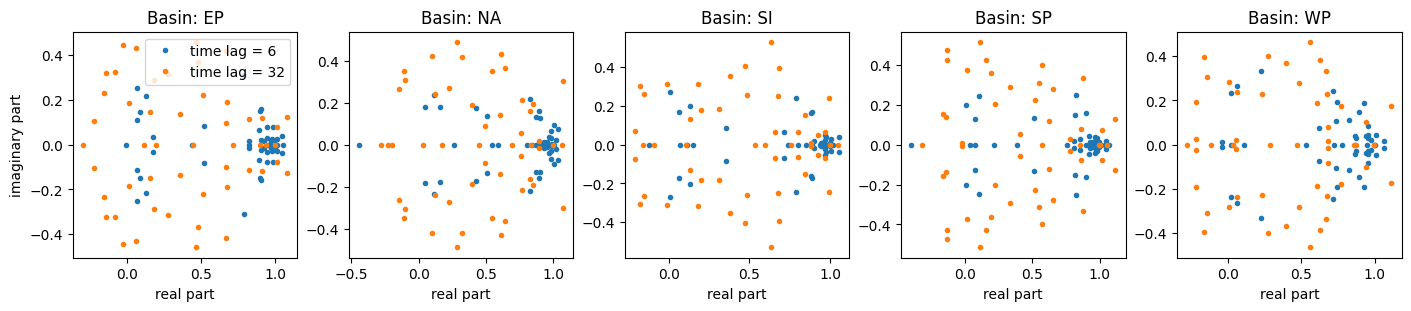

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=len(basins), constrained_layout = True)
fig.set_size_inches(14,3)

context_length = context_lengths[0]


eval_range = range(1, 19, 2)
# eval_range = [1, 2, 3, 5, 8]

for idx_b, basin in enumerate(basins):
    time_lag = time_lags[5]
    ax[idx_b].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, color=f"C{0}", marker=".", label=f"time lag = {time_lag}", linestyle="None")
    time_lag = time_lags[-1]
    ax[idx_b].plot(evals[context_length][basin][time_lag].real, evals[context_length][basin][time_lag].imag, color=f"C{1}", marker=".", label=f"time lag = {time_lag}", linestyle="None")

    ax[idx_b].set_title(f"Basin: {basin}")
    if idx_b == 0:
        ax[idx_b].set_ylabel(f"imaginary part")
    ax[idx_b].set_xlabel("real part")
ax[0].legend()

One observes that `time_lag = 32` leads to a shift in the eigenvalue distribution towards smaller real values. This is the imprint of the increased internal time unit of our system as we increase the `time_lag`. Theoretically, the largest real part of eigenvalues is one. Since our Koopman operator only approximates the actual system, we obtain spurious eigenvalues, some of them having real parts slightly larger than one. Each eigenvalue sets the time scale of the corresponding dynamical Koopman mode. In the following we restrict to only the eigenvalues with real part strictly smaller than one, as those are the more physically relevant ones.

RMSE scaling:

Before we consider the scaling of ITS with `time_lag`, we compare the RMSE of our Koopman kernel model for two choices of `context_length`.

Text(0, 0.5, 'RMSE')

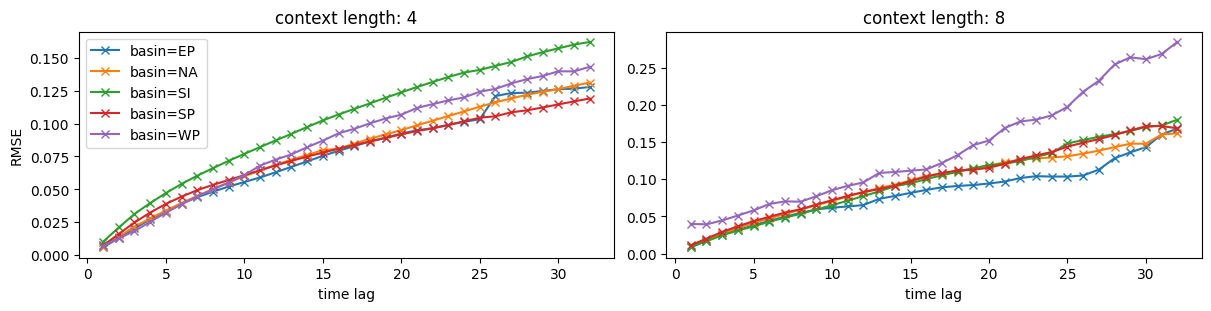

In [9]:
fig, ax = plt.subplots(nrows=1, ncols = len(context_lengths), constrained_layout = True)
fig.set_size_inches(12,3)

for (idx_b, basin), (idx_cl, context_length) in product(enumerate(basins), enumerate(context_lengths)):
    ax[idx_cl].plot(time_lags, errors[context_length][basin].values(), color=f"C{idx_b}", marker="x", label=f"basin={basin}")
    ax[idx_cl].set_title(f"context length: {context_length}")
    ax[idx_cl].set_xlabel("time lag")
ax[0].legend()
ax[0].set_ylabel("RMSE")

For increasing `time_lag`, the RMSE increases. Both context lengths show quite a similar behaviour.

Implied time scale:

In the following we plot implied time scales as a function of the `time_lag`. We consider, as before, the five most important basins and two context length parameters. Colours correspond to different eigenvalues, which we label by their index. The eigenvalues are ordered in descending order according to their real parts, starting with the eigenvalue with largest real part below one.

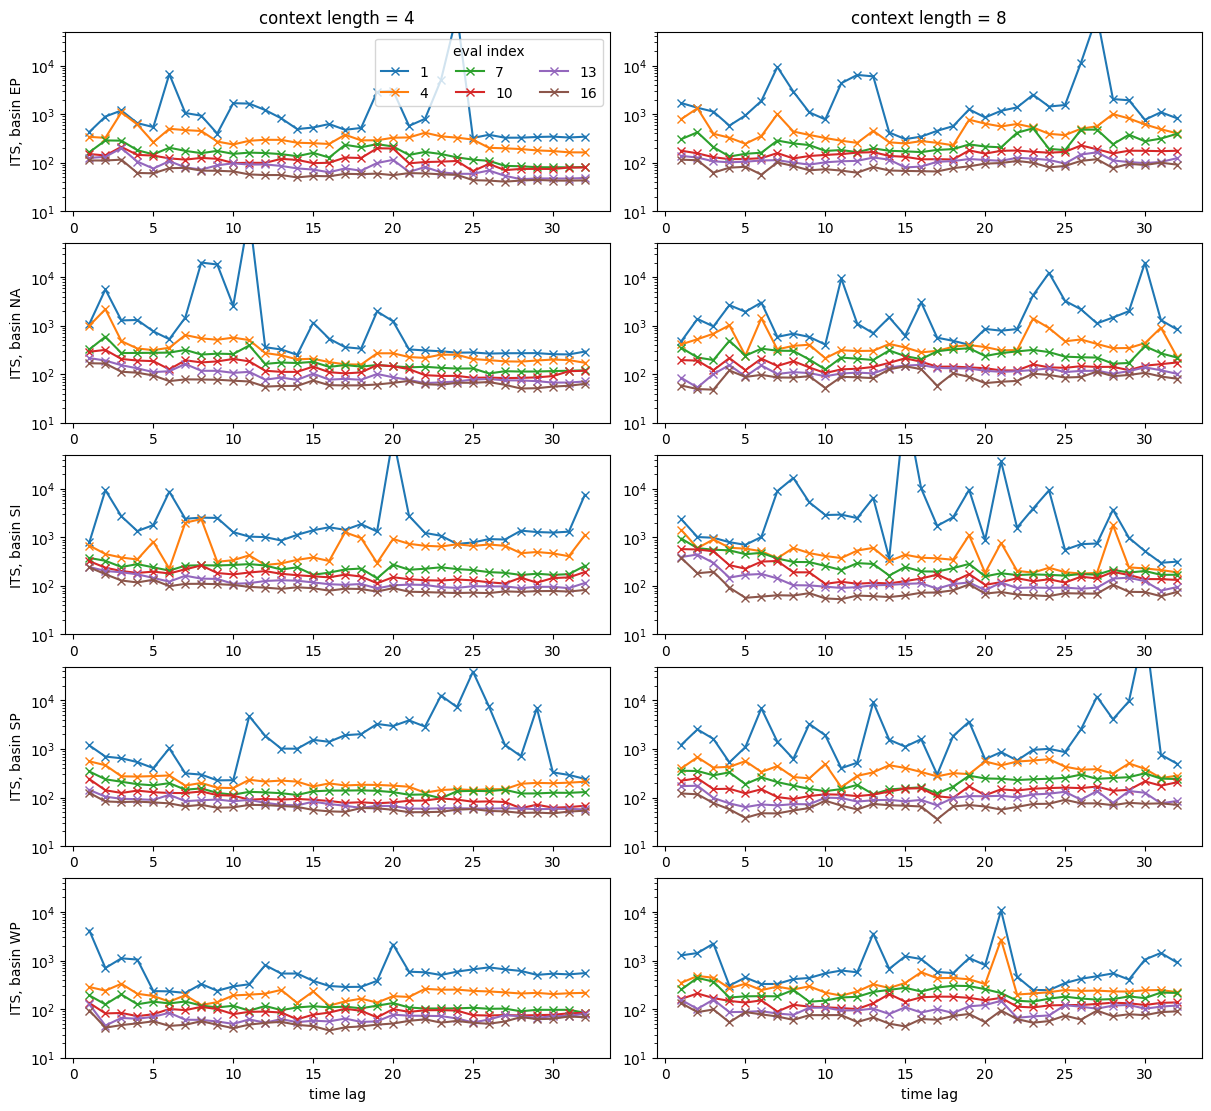

In [11]:
fig, ax = plt.subplots(nrows=len(basins), ncols = len(context_lengths), constrained_layout = True)
fig.set_size_inches(12,11)

eval_range = range(1, 19, 3)
# eval_range = [1, 2, 3, 5, 8]
for (idx_b, basin), (idx_cl, context_length) in product(enumerate(basins), enumerate(context_lengths)):
    for idx_eval_c, idx_eval in enumerate(eval_range):
        ax[idx_b, idx_cl].plot(time_lags, [ts[idx_eval] for ts in time_scales[context_length][basin].values()], color=f"C{idx_eval_c}", marker="x", label=idx_eval)
    if idx_b == 0:
        ax[idx_b, idx_cl].set_title(f"context length = {context_length}")
    if idx_b == len(basins) - 1:
        ax[idx_b, idx_cl].set_xlabel("time lag")
    ax[idx_b, idx_cl].set_yscale("log")
    ax[idx_b, idx_cl].set_ylim(1E1, 5E4)
    ax[idx_b, 0].set_ylabel(f"ITS, basin {basin}")
ax[0,0].legend(title="eval index", ncols=3)

We nicely observe that almost all ITS are constant with `time_lag`. Only the eigenvalues close to one are quite unstable, and result in strongly fluctuating implied time scales. This is expected, since they are so close to one, which has infinite time scale.

#### Save simplified plot

Consider `context_length = 4`.

In [4]:
num_centers = 800
tikhonov_reg = 1E-8
reduced_rank = True

# time_step_h = 0.5
time_step_h = 1.0
time_step_scaling = int(3 / time_step_h)
# BASINS = ["EP", "NA", "NI", "SI", "SP", "WP", "SA"]
basins = ["EP", "NA", "SI", "SP", "WP"]
# basins = BASINS[:-1]
year_range = (1980, 2021)
model_config = {
    "length_scale": 10.0,
    "reduced_rank": reduced_rank,
    "rank": 50,
    "num_centers": num_centers,
    "tikhonov_reg": tikhonov_reg,
    "svd_solver": "arnoldi",
    "rng_seed": 42,
}
context_lengths = [4, 8]
top_k = 20
feature_list = [
    "lon",
    "lat",
    "max_sustained_wind",
    "radius_max_wind",
    "radius_oci",
    "central_pressure",
    "environmental_pressure",
]
time_lags = list(range(1, 33))

evals, errors, time_scales = load_data(time_step_h, year_range, num_centers, tikhonov_reg, context_lengths, time_lags, reduced_rank=reduced_rank)

Load data for context length: 4
Load data for context length: 8


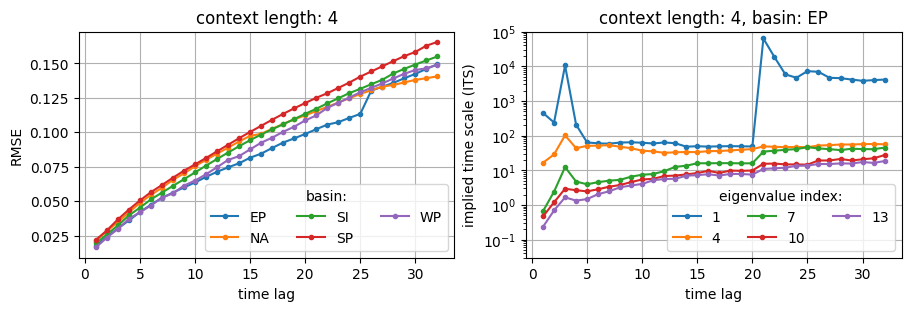

In [5]:
fig, ax = plt.subplots(nrows=1, ncols = 2, constrained_layout = True)
fig.set_size_inches(9,3)

context_length = 4

for (idx_b, basin) in enumerate(basins):
    ax[0].plot(time_lags, errors[context_length][basin].values(), color=f"C{idx_b}", marker=".", label=f"{basin}")
    ax[0].set_title(f"context length: {context_length}")
    ax[0].set_xlabel("time lag")
ax[0].legend(title="basin:", ncols=3)
ax[0].set_ylabel("RMSE")
ax[0].grid()


basin = "EP"
eval_range = range(1, 15, 3)
for idx_eval_c, idx_eval in enumerate(eval_range):
    # ax[1].plot(time_lags, [ts[idx_eval] for ts in time_scales[context_length][basin].values()], color=f"C{idx_eval_c}", label=idx_eval)
    ax[1].plot(time_lags, [ts[idx_eval] for ts in time_scales[context_length][basin].values()], color=f"C{idx_eval_c}", marker=".", label=idx_eval)

ax[1].set_title(f"context length: {context_length}, basin: {basin}")
ax[1].set_xlabel("time lag")
ax[1].legend(title="eigenvalue index:", ncols=3, loc=4)
ax[1].set_ylabel("implied time scale (ITS)")
ax[1].set_yscale("log")
ax[1].set_ylim(3E-2, 1E5)
ax[1].grid()


save_path = os.path.join(
    "../plots/", "koopman_spectral_analysis/", "time_lag_scaling/"
)
os.makedirs(save_path, exist_ok=True)
fig.savefig(os.path.join(save_path, "time_lag_scaling_ctlen4.png"), bbox_inches='tight')